In [29]:
using DrWatson
using ITensors, HDF5, Plots, LinearAlgebra, Kronecker, Dates, ITensorMPS, LaTeXStrings, FFTW, ZChop 
using IteratorSampling, PolyChaos, Polynomials, QuadGK
using SpecialFunctions, SparseArrays
#using QuantumToolbox
ITensors.disable_warn_order()

In [30]:

"""
    extract_diag(mat, l)

Extracts the l-th diagonal of a matrix.

# Arguments
- `mat`: Matrix from which to extract the diagonal.
- `l`: Offset of the diagonal to extract (0 for the main diagonal, >0 for superdiagonals, <0 for subdiagonals).

# Returns
- A vector containing the elements of the specified diagonal.
"""
function extract_diag(mat, l)
    if l >= 0
        idx = 1:min(size(mat, 1), size(mat, 2) - l)
        return [mat[i, i + l] for i in idx]
    else
        l = abs(l)
        idx = 1:min(size(mat, 1) - l, size(mat, 2))
        return [mat[i + l, i] for i in idx]
    end
end

"""
    _wig_laguerre_val(L, x, c)

Computes the weighted Laguerre polynomial values using Clenshaw recursion.

# Arguments
- `L`: Integer degree of the Laguerre polynomial.
- `x`: 2D array of squared amplitudes `|A2|^2`.
- `c`: Vector of coefficients.

# Returns
- A 2D array of Laguerre polynomial values weighted by the coefficients.
"""
function _wig_laguerre_val(L, x, c)
    #c_L = _wig_laguerre_val(L, x, diag(rho, L))
    """
    this is evaluation of polynomial series inspired by hermval from numpy.    
    Returns polynomial series
    sum_n b_n LL_n^L,
    where
    LL_n^L = (-1)^n sqrt(L!n!/(L+n)!) LaguerreL[n,L,x]    
    The evaluation uses Clenshaw recursion
    """

    n = length(c)
    
    # Special cases for short coefficient arrays
    if n == 1
        return c[1]  # Single coefficient case
    elseif n == 2
        y0, y1 = c[1], c[2]
    else
        y0, y1 = c[end-1], c[end]
        for k in reverse(3:n)
            factor1 = sqrt((k - 2) * (L + k - 2) / ((L + k - 1) * (k - 1)))
            factor2 = ((L + 2k - 3) .- x) ./ sqrt((L + k - 1) * (k - 1))  # Broadcasting subtraction
            y0, y1 = c[k-2] .- y1 .* factor1, y0 .- y1 .* factor2  # Broadcasting subtraction and multiplication
        end
    end

    # Final term
    return y0 .- y1 .* ((L + 1) .- x) ./ sqrt(L + 1)  # Broadcasting subtraction and division
end

"""
    wigner_clenshaw(rho, xvec, yvec, g = sqrt(2), sparse = false)

Calculates the Wigner function using Clenshaw summation for numerical stability and efficiency.

# Arguments
- `rho`: Density matrix, either dense (2D array) or sparse (CSR format).
- `xvec`: 1D array of x-coordinates for the grid.
- `yvec`: 1D array of y-coordinates for the grid.
- `g`: Scaling factor for the Wigner function (default `sqrt(2)`).
- `sparse`: Boolean indicating if the density matrix is sparse (default `false`).

# Returns
- A 2D array representing the Wigner function over the specified grid.
"""
function wigner_clenshaw(rho, xvec, yvec, g, sparse)
    """
    The Wigner function is calculated as
    :math:`W = e^(-0.5*x^2)/pi * sum_{L} c_L (2x)^L / sqrt(L!)` where 
    :math:`c_L = sum_n rho_{n,L+n} LL_n^L` where
    :math:`LL_n^L = (-1)^n sqrt(L!n!/(L+n)!) LaguerreL[n,L,x]`
    
    """
    M = size(rho, 1)  # Dimension of the density matrix
    # Compute the 2D grid of complex coordinates
    X = xvec'  # Transposed x-coordinates for broadcasting
    Y = yvec   # y-coordinates
    A2 = g * (X .+ 1im .* Y)  # Scaled complex amplitudes A2 = 2 * A

    # Precompute squared magnitude of A2
    B = abs2.(A2)
    # Initialize the Wigner function with the last diagonal's contribution
    w0 = (2 * real(rho[1, end])) * ones(Complex{Float64}, size(A2))
    L = M - 1  # Maximum degree of the summation

    if !sparse
        # Dense matrix mode
        local_rho = copy(rho)  # Make a local copy to avoid modifying input
        local_rho .= local_rho .* (2 .- I(M))  # Subtract identity matrix I(M)
        diag_cache = [extract_diag(local_rho, l) for l in 0:L]  # Precompute all diagonals
        for l in reverse(0:L-1)  # Iterate over degrees in reverse
            diag = diag_cache[l + 1]
            w0 .= _wig_laguerre_val(l, B, diag) .+ w0 .* A2 .* inv(sqrt(l + 1))
        end
    else
        # Sparse matrix mode
        data, indices, indptr = sparsematrix_parts(rho)  # Extract CSR components
        for l in reverse(0:L-1)  # Iterate over degrees in reverse
            diag = _csr_get_diag(data, indices, indptr, l, M, M)  # Extract L-th diagonal
            if l != 0
                diag .= diag .* 2  # Scale non-zero diagonals
            end
            w0 .= _wig_laguerre_val(l, B, diag) .+ w0 .* A2 .* inv(sqrt(l + 1))
        end
    end
    dx = step(xvec)  # Grid spacing in x-direction
    dy = step(yvec)  # Grid spacing in y-direction
    #ſ@show normalization = sum(real(w0) .* exp.(-B * 0.5)) .* (1/ π) * dx * dy
    W = real(w0) .* exp.(-B * 0.5) .* (1/ π) #.*(1/normalization)


    # Compute the final Wigner function
    return real(W)
end

wigner_clenshaw

In [31]:
rho11o1 = [0.3590508130911515 0.0024813187249426334 0.0002691952451469036 4.76113926616487e-5 9.696201390569546e-6 4.240398358753998e-7 3.345308024869505e-7 1.1258232543029661e-7 6.360630877494663e-8 1.0575660879314219e-7 5.189158286635583e-8 4.192992085563623e-8 1.0092572466706218e-7 7.572817611212911e-8 5.813115276494956e-8 6.760945883193725e-8; 0.002332760396955583 0.2042110045730197 0.0034120436304995345 5.2514544073690024e-5 5.6428556127430725e-6 1.9833925677647396e-6 2.1518713390319905e-7 1.1055084045925307e-7 3.513813872333062e-8 2.693075949951925e-8 1.2771281474839224e-7 2.9453544310207044e-8 5.8270419680533715e-8 7.090399297301345e-8 9.6869077066111e-8 6.428712993350637e-8; 0.00026757770483789493 0.003444578795558137 0.10956046242010978 0.0023666040781235177 5.2455107079985366e-5 3.43360466861237e-7 1.540152399696148e-7 2.1336343212547992e-7 6.382292330501082e-8 3.3584277791547786e-8 4.9485205138835945e-8 9.101258320792179e-8 4.49783558408688e-8 5.404990669149854e-8 2.7571767538337903e-8 7.386769978981629e-9; 5.123823551274128e-5 7.040187782897184e-5 0.0023736486128854988 0.05660228905356065 0.0014691970414395254 3.77619973632995e-5 6.997135124993245e-7 1.4346161550679638e-7 1.4276541686494089e-7 7.706770475321118e-8 8.853613455288408e-8 8.271296744558154e-8 6.324721912192953e-8 6.293501365460177e-8 5.939840998351554e-8 7.077072698576891e-8; 8.11047900441735e-6 6.4930937731056385e-6 5.252470087957539e-5 0.001468901341647244 0.028136195718784368 0.0008751130038100118 2.4487255332221306e-5 2.1620581903922395e-7 2.6012223255269977e-7 1.0487001724993202e-7 1.8349083759935281e-7 1.2833474206116886e-7 6.454419445950354e-8 6.373557977263381e-8 3.2308302120093646e-8 1.2586512133697284e-8; 1.4170766718273747e-6 2.0533682102558363e-6 9.277470393624674e-7 3.7360604198065855e-5 0.000875872703657524 0.012972105742150013 0.0005150856639826232 1.8532172416488237e-5 1.593897035746939e-7 1.231705718640476e-7 1.5925597970911553e-7 3.994389838065075e-8 8.855455889659847e-8 9.760193280599249e-8 8.128988100589959e-9 9.858178942391644e-8; 2.163588265603266e-7 3.6055369770606935e-7 1.458118175864805e-7 6.689675991954721e-7 2.488131781836341e-5 0.0005112247259366942 0.004871822684202689 0.00025075084736453823 1.3548538370169324e-5 5.432242257889668e-7 1.530227213017992e-7 1.1100647473406908e-7 8.596963256042857e-8 1.7668789029679846e-7 1.682201707744383e-8 1.1204028740285624e-7; 3.341940660708947e-8 1.420294726260626e-7 1.2688727643333418e-7 5.405424242947099e-8 7.241360063750981e-7 1.8284079740201485e-5 0.00025046769599159935 0.0012097472171465477 6.003114528855686e-5 2.8031294712498736e-6 2.431520436658697e-7 3.163356843906678e-7 2.2296229861707097e-7 1.0316236790524933e-7 2.2510271594120925e-7 4.4425118235009616e-8; 1.0401985362904048e-7 3.448808120074589e-8 2.834039830013934e-8 7.340117518326954e-8 2.2210408089553134e-7 4.175548959018621e-7 1.3694488733126482e-5 5.7956904465482604e-5 0.0004013890926484655 1.792600692649159e-5 1.332052079097631e-6 4.347006820860645e-7 3.875419906896332e-7 1.8610282681094025e-7 1.3590165333941863e-7 8.307280433097023e-8; 6.6983424186094e-9 2.937685694260729e-8 1.0123988631811273e-7 9.210635448036271e-8 1.2382165204875145e-7 2.446674470826724e-7 6.012643384855663e-7 3.033033281252418e-6 1.826019709985049e-5 0.00016254210556343205 8.40213486042429e-6 5.868679240179534e-7 3.019583673615494e-7 4.814312442271947e-7 1.4296397923943264e-7 1.299178193722815e-7; 3.708828656173193e-9 5.582471788722763e-8 1.0128763329389538e-8 1.0099422853140731e-7 2.511506656120785e-7 1.51392523963564e-7 4.2899967190220027e-7 2.1448290871630714e-7 7.8423540862724e-7 9.493568635168004e-6 6.410788580027882e-5 3.7342282653782427e-6 3.589710898623765e-7 3.6991673147328497e-7 1.9824104072461328e-7 1.5270100257340961e-7; 9.498043637838716e-9 5.7826529488655694e-8 3.374657225265409e-8 1.1559124000312468e-7 1.2068694581398412e-7 8.846760028413045e-8 1.0550455436243107e-7 4.778985720778095e-7 3.576147610355155e-7 3.8411985153273504e-7 3.603679070281104e-6 3.073053970859831e-5 5.525426646767811e-7 5.985122054649607e-7 1.0378175560849653e-7 2.8315727611846494e-7; 1.4103723908945095e-8 3.3086722487928076e-8 1.32696841135171e-7 5.850172648524662e-8 1.0165630503359019e-7 1.2628355544199394e-7 7.77767757782742e-8 2.655648854707547e-7 3.8933716081462243e-7 2.2548747605666808e-7 6.131236695885461e-8 1.8628016635293661e-6 2.463331536424229e-5 1.8868161850457479e-6 7.415944300119136e-7 4.4272002750437813e-7; 1.9651607593861583e-9 3.5002425019466383e-8 8.73587323901236e-8 6.675391192252321e-8 5.325505869721895e-8 4.829989134679834e-8 2.5713976331101037e-8 6.790759044358251e-8 1.7317317040809454e-7 5.270664938415784e-8 3.977646647628341e-7 9.428664674489137e-7 4.063521853414841e-7 2.246411069904126e-5 1.1123605019263827e-6 3.2489970148127224e-7; 9.57081772156714e-9 5.489241399912685e-8 1.480501746877656e-8 3.0962370102561186e-8 3.5120206705329436e-8 4.9666057326765404e-8 3.946364220411676e-8 1.3517263390819726e-7 3.2892983907443177e-7 1.8861299464974966e-7 2.7836843068518914e-7 4.3261280241807117e-7 5.497227880522831e-7 7.345894025155058e-7 1.8798180655150136e-5 9.666517278134071e-7; 1.8350967145145556e-9 6.848103290428555e-8 9.27483828880666e-8 3.796544751947702e-8 4.015139841050551e-8 7.405661219185224e-8 5.3126656901845905e-8 3.7698965247070045e-8 1.3034841136545864e-7 2.1855136108223265e-7 3.370009711579555e-7 7.265507559972927e-8 2.8999884440208804e-7 1.5351634593611613e-7 1.1955114337583546e-6 2.3663415701603234e-5];
rho1o11 = [0.35298812664626994 0.004411829132642897 0.00028784557154157373 4.0397591653911566e-5 6.365851220180518e-6 4.7449668902846955e-7 7.067955133346717e-7 2.271437872082325e-7 1.1330198402820012e-7 7.379294021463353e-8 2.5290573606126637e-8 9.941884074649877e-8 1.461422477452236e-10 7.358365264715342e-11 2.520429953170885e-11 9.918685343079524e-11; 0.00452143405772554 0.2045291997364473 0.0032788616166949426 7.233653679404631e-5 9.283115157377055e-6 1.4004854694886043e-6 1.308544167084061e-7 1.7933363587488861e-7 1.653273386235323e-7 7.239494533898791e-8 5.5969805448274616e-8 1.8954494197402584e-8 1.644309229329475e-10 6.843323802027224e-11 5.553274638683089e-11 1.8920463515474023e-11; 0.0003142337732760953 0.0032845409550640702 0.1127593999199011 0.0023050218963768304 5.127670399891485e-5 3.6928603713839054e-7 1.7745194927606987e-7 2.949404585693427e-8 1.5922343586220115e-7 5.768102154440761e-8 9.899412806478835e-8 7.061892185557891e-8 1.5870080095922203e-10 5.714630391749895e-11 8.458742489032298e-11 7.016556792907782e-11; 3.968405724829464e-5 8.329577131569298e-5 0.0022878663097352274 0.06025423811815922 0.0014934748516845584 3.531538012235468e-5 5.325817109363813e-7 8.364944797509284e-8 1.4423707544026592e-7 4.263105948106524e-8 1.677876339946236e-7 8.825161083466929e-8 1.396598904994708e-10 4.244649895589084e-11 1.6769680836760937e-10 9.425891526161405e-11; 5.6844216770402475e-6 8.320766675315025e-6 5.2804016433893144e-5 0.001491809422652594 0.030678058646417303 0.00094882774015693 2.648407226639283e-5 3.094371923585757e-7 2.0323486379363576e-8 7.227160376875113e-8 7.043458651196576e-8 2.0739161362266568e-8 1.1291987473482278e-10 7.166094344317842e-11 7.021271833209305e-11 2.0838362174611966e-11; 3.385269876300976e-7 1.1713865980266945e-6 9.507282434834301e-7 3.5168300847670045e-5 0.0009486974472077675 0.013857229781748042 0.0005552648269430766 2.0804489892437546e-5 3.4022576823405217e-7 1.499897501029264e-7 8.283881781117331e-8 1.3970106660261372e-7 3.3786862073652213e-10 1.6528841392582336e-10 8.116859360361696e-11 1.39365218609161e-10; 1.636303682369577e-7 6.81980000669508e-7 3.6076814789170713e-7 5.236640296292182e-7 2.6331567158959553e-5 0.0005561216873691007 0.0048596439241535795 0.0002569388682113675 1.3965063263919888e-5 2.705965180120007e-7 9.875197503542788e-8 3.843450196253723e-8 1.3932475113417408e-8 2.6904373393808706e-10 1.0841234313317439e-10 3.818753940301895e-11; 1.6306956421890542e-7 2.277477945948883e-7 4.5857966748768194e-8 1.76606043003969e-7 3.934447993445123e-7 2.0729223033558216e-5 0.0002572171498394915 0.0010099504600543758 5.671904912332936e-5 3.1702701795945946e-6 8.061935029473766e-8 1.1876089744589553e-7 5.6587033075525094e-8 3.1628226090137897e-9 8.077960422656575e-11 1.1475545115103089e-10; 1.0097921201813537e-7 1.039561200941765e-7 1.4070247843014292e-7 9.431183162383523e-8 1.1085602371124107e-7 2.3601801499250637e-7 1.444814630316408e-5 5.723755086020278e-5 0.00020477899079825876 1.174082584710982e-5 2.0138077197069255e-6 2.9636313288376355e-7 2.0430236357367894e-7 1.1713498301682147e-8 2.0090795742959983e-9 2.958945449354058e-10; 5.156930245329338e-8 4.057585519286446e-8 1.2779673484698742e-7 3.391951329376953e-8 8.173991783457158e-8 1.2267488029055816e-7 7.759991644068899e-7 2.5676133888542226e-6 1.1090420342530547e-5 5.427086767160631e-5 2.5417166176776316e-6 5.371302451367422e-7 1.1064607069062352e-8 5.4144551491746247e-8 2.5357989680613236e-9 5.358728866293899e-10; 2.1533350093547047e-8 2.763242234028129e-8 6.75738811046368e-8 4.476916892123192e-8 6.381474743908702e-8 6.54685326654775e-8 1.895028430470486e-7 9.875488378108954e-8 7.360192827530549e-7 3.506063530708201e-6 1.4507265020017804e-5 1.2096503782923823e-6 7.343064255786406e-10 3.4979028527729958e-9 1.4473498605640928e-8 1.2068351588781771e-9; 2.1052857484835757e-8 1.1475229703840278e-8 7.706333012962177e-8 3.876928469922486e-8 4.4121371683159016e-8 7.2069072881911e-8 1.9566403173587248e-7 2.208962634269427e-7 2.3152266630206614e-7 2.457158004891398e-7 9.33725148691615e-7 6.797079067244131e-6 2.309839656546408e-10 2.4514378571742574e-10 9.315515194843756e-10 6.7812590398453715e-9; 7.76382483291844e-9 2.3893908956081503e-8 2.2740828742281885e-8 2.1665918173601206e-8 3.814774166122541e-8 8.004312350472076e-9 1.1620113556837484e-7 6.83236895167947e-8 1.6969782018086956e-7 2.556314886646199e-7 2.7508540883345255e-7 9.069328900284547e-7 1.693029792058927e-10 2.550365167731073e-10 2.7444516268185543e-10 9.048217372848558e-10; 4.431674888653225e-8 5.262562939923511e-8 4.442137234659657e-8 7.23151650684618e-8 1.8758996576911528e-8 9.807549609629447e-8 9.497509074145247e-8 1.190767853029223e-7 1.512792290262042e-7 2.3513111686744037e-7 1.9730966341195355e-7 2.702922721807315e-7 1.5092717447583784e-10 2.3458347277075394e-10 1.96850780467065e-10 2.6966314201869236e-10; 3.994968177378533e-8 2.1349995074634996e-8 2.6944995098340313e-8 4.65493573356352e-8 4.903879821770286e-8 1.8908022262810233e-8 1.4472235622987798e-7 8.279462947580488e-8 1.6077909480816206e-7 1.163950687975002e-7 3.159178821753739e-8 7.557306934742108e-8 1.6040476345864218e-10 1.1612419624578918e-10 3.151770030065171e-11 7.539711007962671e-11; 1.3379852824436362e-8 4.6079530739518786e-8 2.1251766358654925e-8 3.230413303821006e-8 4.3668965590047165e-8 4.869322547745066e-8 9.386317318767764e-8 6.263430606583263e-8 1.4402365032286955e-7 2.504496620647192e-7 7.724402982435627e-8 1.230147409407203e-7 1.4368832199392012e-10 2.4986683710083987e-10 7.706431422891846e-11 1.2272820355160325e-10];
rhoo111 = [0.34613580643590786 0.004161142099848452 0.00034063732219311114 4.794350166498771e-5 9.157997135145477e-6 2.527407638170115e-6 1.030985702349731e-6 2.4969004255415415e-7 6.845637955424284e-8 5.211300876652558e-8 7.094588201361722e-8 2.029880781571517e-8 5.6774751599294416e-9 1.4103069514730773e-8 1.6306452085502466e-8 1.747441757576026e-8; 0.004206268021909985 0.20452301292462105 0.003104278048312513 7.266156155356371e-5 1.3943930832285149e-5 1.7507568061301016e-6 9.82288548698214e-7 8.407178242031109e-8 1.0039656346278702e-7 1.7413046705909287e-8 2.0189019013362096e-8 8.772124367321539e-9 1.4054373078081857e-8 1.3232109358849792e-8 1.214666791121469e-8 1.2959795861078872e-8; 0.00034794117186500367 0.0031672701511423146 0.11637048528947475 0.002269011331958188 5.292319818280807e-5 8.466907923144604e-7 5.783056838345268e-7 1.1153723918540775e-7 2.0721481457978173e-8 2.3477070193658137e-8 3.303792882694003e-8 2.4116242324214665e-8 1.0669539403022876e-8 9.726405201032306e-9 1.843365283923399e-8 3.4669933197899084e-8; 5.068035463596137e-5 7.569012229998548e-5 0.0022624573060833226 0.0641522009940596 0.0015125359173516603 3.4151576941729985e-5 7.229012490731063e-7 3.1699622686800146e-8 7.425193384069186e-8 4.6922080313275077e-8 3.591037844781043e-8 2.3790410975316952e-8 2.3021189656239446e-8 2.4971019943879196e-8 1.4130069277917894e-8 2.0406323350679228e-8; 8.223638198132532e-6 1.3723965800311091e-5 5.3459603169270475e-5 0.001510690440205521 0.033974496863233714 0.0009910997062527627 2.6272676423783734e-5 4.823818847348672e-7 8.13489566585647e-8 7.394641179660128e-8 2.5035486635228635e-8 3.9100227777936554e-9 3.724852665560989e-8 1.8084452821680418e-8 1.7652754244099934e-8 1.6701603449296714e-8; 1.6835470496758338e-6 1.8493415851878253e-6 6.033385989208433e-7 3.420664614073302e-5 0.000991883797366693 0.01625534014974467 0.0006030551262351532 1.990174331535429e-5 2.3111724810109748e-7 6.723779759127596e-8 5.018268722600871e-8 6.127108846973997e-8 2.4101240866826144e-8 4.6591175049249205e-8 2.5471773218222976e-8 2.3429317170237115e-8; 6.67901574311201e-7 6.645221150455955e-7 3.6904232763435504e-7 6.921743557798062e-7 2.6363627464728923e-5 0.0006028334399372896 0.006398074644949359 0.00031523423752695585 1.5692904889501967e-5 4.3111873953745097e-7 1.1280358311111927e-7 4.335395304518091e-8 3.060278329422511e-8 2.9836022962869153e-8 6.47479653533015e-8 4.284405430228185e-8; 1.1444946648885967e-7 1.2029196905635426e-7 2.4177378677782857e-8 1.872432822882463e-7 3.473606795681185e-7 2.0419021043810685e-5 0.00031641551143478066 0.001632679834215931 9.582627905707835e-5 5.9707964274225055e-6 3.116191408754743e-7 6.23726855720936e-8 1.1437354956843025e-7 5.543146550787092e-8 3.426116131738804e-8 5.868790864722268e-8; 6.924445939542615e-8 4.473961303643975e-8 1.4677972293251131e-8 6.1493058383756566e-9 3.196521082633856e-8 3.352889019307051e-7 1.5633579806736047e-5 9.527602199739098e-5 0.0002797642792450851 1.4276765617535384e-5 8.686371111244158e-7 2.0080945493998726e-8 1.983027469352864e-7 2.0020998435049976e-7 6.110093395912065e-8 6.210733293941779e-8; 2.2941236060907783e-8 1.216979934863863e-8 4.423722698757119e-8 1.9181590940406277e-8 8.717890820618094e-9 1.0919780896631835e-7 6.249838182213066e-7 6.190907436002775e-6 1.4643144338770532e-5 9.168763730563236e-5 4.948818569101374e-6 1.025590602641504e-6 2.5332408957371167e-7 1.4809448829262209e-8 6.561631834586081e-8 2.1710983281145837e-7; 4.768072141056786e-8 4.416942865164901e-8 4.493938771094769e-8 3.1044876943767794e-8 5.427182256001243e-8 6.447463196341552e-8 1.0116636406368054e-7 3.348895790183089e-7 8.05968645884675e-7 5.139317343263238e-6 4.720833789667735e-5 9.574606383671592e-7 5.727373889974238e-7 3.2488307203829596e-7 1.5805138394686285e-7 2.2919266779693141e-7; 5.2144544930290934e-8 4.5879298756300266e-8 1.1788396384407316e-8 1.7694071339867827e-8 2.980139971366961e-8 5.680188063440058e-8 9.366446552743818e-9 1.6518272227926166e-7 2.9535029460302236e-8 1.0074915740509065e-6 1.5763833563143505e-6 3.070669665003534e-5 3.5524947890954715e-6 2.639306088162343e-7 3.871333191719994e-7 8.573743336208457e-8; 2.1633546864867568e-8 4.091059098075799e-8 2.9298900020981282e-8 2.4966896430139736e-8 3.991938045649458e-8 1.1320946876335695e-8 1.2632148428028755e-8 5.6309912669320145e-8 3.232312130218362e-7 2.0353365007054445e-7 3.636509410773215e-7 9.581838895955788e-7 2.6984393030454483e-5 1.8094931704528648e-7 3.2006998756641833e-7 5.766502414462202e-7; 6.311317953557011e-8 3.6848795509218426e-8 3.554966902383846e-8 4.128522581402967e-8 4.1510544041623524e-8 5.0849234620213276e-8 3.0093796247806866e-8 3.509532144764225e-8 3.6051517527738636e-8 3.1062763172518403e-7 1.0809915516368775e-7 2.8764833138753186e-7 4.080856416707585e-7 2.2123016550664893e-5 2.793850088216308e-6 2.5770811539996667e-7; 1.1113486613558043e-7 1.4056146761739698e-8 2.6714250276033562e-8 9.501884910251998e-9 1.3918471041784937e-8 4.413348160517636e-8 6.317297118881775e-8 7.859918029596561e-8 1.878497370657392e-7 1.7513454590056144e-7 2.8309063595939536e-7 1.4194549543310633e-7 2.995389022731969e-7 6.618604264756528e-7 2.463509787554857e-5 7.028541110877784e-7; 4.1191184785203824e-8 1.791903650773495e-8 1.7046034638449254e-8 1.3406508859724015e-8 2.0175854679142187e-8 1.5997826943428284e-8 5.0925420620907234e-8 3.7736005482280105e-8 6.990651191524319e-8 1.4116551818411988e-7 1.0440664341410761e-7 2.6303445989539225e-7 7.481089592609459e-8 2.0401659358131747e-7 2.8845871105018746e-7 2.041334169683655e-5];

In [32]:
# Plot the Wigner function as a heatmap
	# Define custom colors with white for zero
	color_min = RGB(50 / 255, 200 / 255, 100 / 255)   # Bright green for negative values
	color_mid = RGB(1, 1, 1)                    # White for zero
	color_max = RGB(255 / 255, 100 / 255, 100 / 255)  # Bright pink for positive values

	# Create a custom color gradient with white at the midpoint
	custom_colormap_with_white = cgrad([color_min, color_mid, color_max], [0.0, 0.5, 1.0])
    # Phase-space for Wigner function
	xvec = range(-12, 12, length = 150)  # x-coordinates
	yvec = range(-12, 12, length = 150)  # y-coordinates

-12.0:0.1610738255033557:12.0

In [40]:
W = wigner_clenshaw(rhoo111/tr(rhoo111), xvec, yvec, sqrt(2), false)
			dx = step(xvec)  # Grid spacing in x-direction
            dy = step(yvec)  # Grid spacing in y-direction
			#W1 = wigner_tbox(density_matrix,xvec,yvec)
            @show sum(W) * dx * dy

sum(W) * dx * dy = 0.9999999999999998


0.9999999999999998

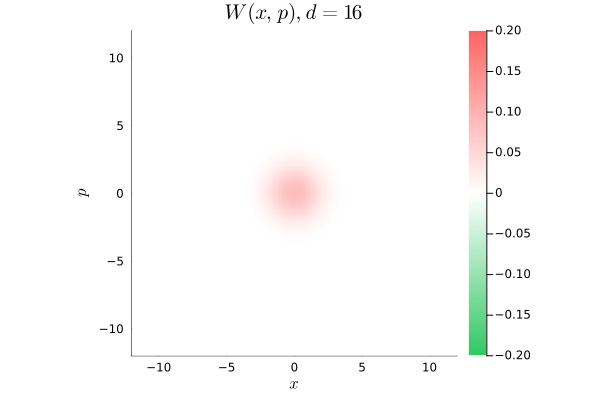

In [41]:
p = heatmap(
				xlim = (minimum(xvec), maximum(xvec)), ylim = (minimum(yvec), maximum(yvec)),
				xvec, yvec, W,
				color = custom_colormap_with_white,  # Custom colormap with white at zero
				xlabel = L"x", ylabel = L"p",
				title = L"W(x,p), d = 16",
				#colorbar_title="Value",           # Label for the color bar
				clim = (-0.2, 0.2),                # Adjust the range to highlight negative regions
				aspect_ratio = 1.0,               # Set the aspect ratio to 1:1
			)
			display("image/png", p) # heatmap(W))

In [43]:
#heatmap(rhoo111/tr(rhoo111), yflip = true, c =:acton10, clims = (0, 0.01))